### Setup

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from Bio import SeqIO

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0,'/fast/AG_Ohler/frederick/projects/mlcis/utils')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import BatchNormalization


seed = 42
np.random.seed(seed)

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [ ]:
def onehot_var(df, col='five_utr',seq_len=50):
    '''
    takes a column of a param:df specified in param:col and one-hot encodes the dna sequence entries
    into one-hot matrices of equal dimension. Pads to param:seq_len if sequences are shorter than param:seq_len.
    '''
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])

    for i,seq in enumerate(df[col].str[:seq_len]): 
        
        seq=seq.lower()
        vec=np.array([nuc_d[x] for x in seq])
        
        while vec.shape[0]<seq_len:
            vec=np.vstack((vec,np.zeros(4)))
    
        vectors[i]=vec

    return vectors



def predict_targets(df, model, name, seq_col='five_utr', seq_len=50, target='log2TE', use_scaler=True, which='log2TE'):
    '''
    takes a param:df with dna sequences, creates a 3d numpy array with a number of one-hot encoded sequences and predicts param:target values (after scaling them) using a param:model.
    then rescales the predicted values obtained from param:model using param:scaler and adds them to the param:df as new param:column.
    '''

    #one-hot encode sequences and predict target
    out = model(onehot_var(df, seq_col, seq_len))

    #define scaler and fit to input distribution
    if use_scaler and which == 'log2TE':
        scaler = preprocessing.StandardScaler()
        scaler.fit(df[target].values.reshape(-1,1))

        #add rescaled predicted values to df as new column
        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = scaler.inverse_transform(out)

    #use scaler from original MRL distribution
    elif use_scaler and which == 'MRL':
        mrl_df = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/human_train.csv', sep=',')
        mrl_scaler = preprocessing.StandardScaler()
        mrl_scaler.fit(mrl_df['rl'].values.reshape(-1,1))

        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = mrl_scaler.inverse_transform(out)

    else:
        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = out
    
    
def r2(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue**2, 4)

def r(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue, 4)

### Preprocessing

First, we will preprocess Ribo-Seq data obtained from the orfquant paper (https://doi.org/10.1038/s41594-020-0450-4)
1. Choose all transcripts with ORFs_pM > 1
3. Choose all genes with RNAseq TPM > 1
4. Merge rpf df, rna df and sequence df via transcript id
5. There are multiple ORFs per transcript. Choose ORF with highest ORFs_pM value per gene.
6. Calculate TE by dividing the normalized read counts. Perform log2-transform of the resulting TE values.

Questions
- How can I retain more entries in the final dataframe? How many entries does framepool have per dataset?

#### Data Import and Merging

In [4]:
#import the rpf orfpm counts
rpf = pd.read_csv('hek-orfquant-orfpm.tsv', sep='\t')[['transcript_id', 'gene_id', 'gene_name', 'region.start', 'region.end','ORFs_pM']]

#keep ORF with highest ORFs_pM per gene
len_before = len(rpf)


#keep only ORFs with ORFs_pM > 1
rpf = rpf[rpf['ORFs_pM']>=1].reset_index(drop=True)
len_after_1 = len(rpf)

print('Before removal of multiple transcripts per gene: '+str(len_before))
print('After keeping only transcripts with ORFs_pM > 1: '+str(len_after_1))

Before removal of multiple transcripts per gene: 20816
After keeping only transcripts with ORFs_pM > 1: 18939


In [5]:
#import the rnaseq tpm counts
rna = pd.read_csv('hek-rnaseq-tpm.tsv',sep='\t')
bef_len = len(rna)

#remove transcripts with tpm<1
rna = rna[rna['tpm']>1]
aft_len = len(rna)

#rename target_id column to transcript_id
rna = rna.rename(columns={'target_id':'transcript_id'})

print('Before removal of any transcripts: '+str(bef_len))
print('After keeping only transcripts with TPM > 1: '+str(aft_len))

Before removal of any transcripts: 198093
After keeping only transcripts with TPM > 1: 27351


Extract the 5'UTR sequences corresponding to each transcript. Add them as new column to the merged dataframe using transcript ID as link. After that, collapse to gene level using highest ORFs_pM per gene.

In [6]:
#import the 5utr sequences from fasta (extracted from hg38 release 25 annotation) and make dataframe
seq_ids = []
seqs = []

for seq in SeqIO.parse('5utrs.fa', 'fasta'):
    seq_ids.append(str(seq.id))
    seqs.append(str(seq.seq))

utr = pd.DataFrame({'transcript_id':seq_ids, 'five_utr':seqs})

print('There are '+str(len(utr))+' 5utrs in the utr dataframe before merging.')

There are 78899 5utrs in the utr dataframe before merging.


In [7]:
#merge all three dataframes on transcript_id column

#rpf+ rna
te_data = rpf.merge(rna, on='transcript_id')
print('There are '+str(len(te_data))+' left after merging rpf and rnaseq.')

#add 5utr sequences
utr_data = te_data.merge(utr, on='transcript_id')

print('There are '+str(len(utr_data))+' entries in the final dataframe.')

There are 10433 left after merging rpf and rnaseq.
There are 9419 entries in the final dataframe.


In [8]:
#collapse to gene level; keep transcript with highest ORFs_pM count per gene
utr_data = utr_data.sort_values('ORFs_pM', ascending=False).drop_duplicates('gene_id').sort_index()
len_after = len(utr_data)
print('After keeping only the transcript with highest ORFs_pM per gene: '+str(len_after))

After keeping only the transcript with highest ORFs_pM per gene: 7663


#### Calculate Translation Efficiencies

In [9]:
#make column for translation efficiencies
utr_data['TE'] = utr_data['ORFs_pM']/utr_data['tpm']

#add column with log2-transformed TEs
utr_data['log2TE'] = np.log2(utr_data['TE'])



In [10]:
utr_data

,transcript_id,gene_id,gene_name,region.start,region.end,ORFs_pM,length,eff_length,est_counts,tpm,five_utr,TE,log2TE
0,ENST00000622503.4,ENSG00000187634.11,SAMD11,923928,944581,1.427471,2557,3855.34,224.518,1.31205,GCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGAAGCGGGCTGG...,1.087970,0.121639
1,ENST00000379370.6,ENSG00000188157.13,AGRN,1020123,1056118,25.349964,7323,12009.30,930.088,1.74489,CCCGTCCCCGGCGCGGCCCGCGCGCTCCTCCGCCGCCTCTCGCCTG...,14.528116,3.860776
2,ENST00000379198.3,ENSG00000176022.4,B3GALT6,1232265,1235041,55.801496,2777,3906.28,921.000,5.31200,CCGGCGCGGGCGCC,10.504800,3.392977
3,ENST00000379031.9,ENSG00000169972.11,PUSL1,1308567,1311677,76.212461,1287,1750.79,508.332,6.54145,GTGACCAGGCCGCGTCCGCGCGCGCGCAGGATTCCTGCGCTGGAGG...,11.650698,3.542345
4,ENST00000343938.8,ENSG00000224051.6,CPTP,1324756,1328897,18.187735,2190,3462.91,298.611,1.94279,GAGGGCGGGGCGAGGGCGGGGCGGTGGGCGGGGACGGGGCCCGCAC...,9.361658,3.226764
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9413,ENST00000369660.8,ENSG00000102178.12,UBL4A,154483717,154486670,89.561042,2382,3205.09,1231.240,8.65496,GGTTCCAGCGCGCGCCCGGGGCGGCGGCGCGCGGCGGGGGGTGGTT...,10.347944,3.371272
9414,ENST00000263512.5,ENSG00000126903.15,SLC10A3,154487306,154490690,13.203893,2161,3066.28,158.632,1.16558,GAGGGGCTTCGGTGGGGCGGGGCCCTGACAGGCCGAGCTCGCGGGC...,11.328174,3.501843
9415,ENST00000393562.6,ENSG00000160211.15,G6PD,154531391,154547572,56.191709,2631,3777.69,328.963,1.96192,AGGGACAGCCCAGAGGAGGCGTGGCCACGCTGCCGGCGGAAGTGGA...,28.641183,4.840019
9416,ENST00000369534.7,ENSG00000130830.14,MPP1,154778684,154821007,41.493947,2042,2209.10,485.534,4.95183,GTCCGCGCCCTCCCGGCGCACCGCCTGCGGGGCGGTGACTGGCCCA...,8.379518,3.066867


[(-5.0, 15.0)]

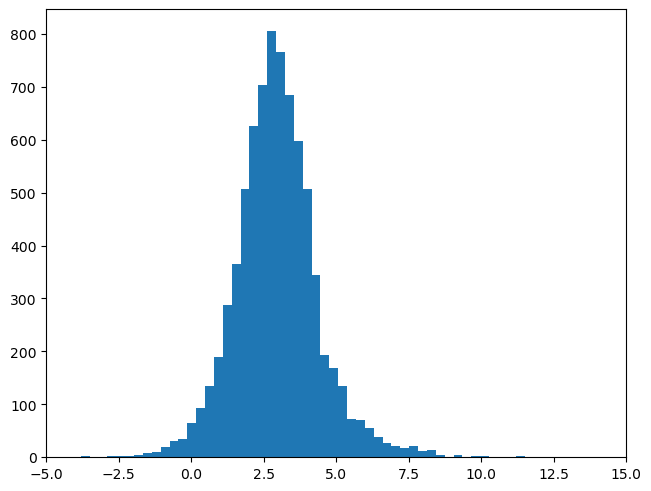

In [17]:
f, ax1 = plt.subplots(ncols=1, layout='constrained')
ax1.hist(utr_data.log2TE, bins=50)
ax1.set(xlim=(-5,15))


#### Subset and Encode Datasets

In [12]:
#add utr length as new column to utr data df
utr_len = []
for row in utr_data.five_utr:
    utr_len.append(len(row))
utr_data['utr_len'] = utr_len

#consider only utrs shorter than 50nt
short_utrs = utr_data[utr_data['utr_len'] <= 50]

#consider only utrs between 25-100nt
medium_utrs = utr_data[utr_data['utr_len'] <= 100]
medium_utrs = medium_utrs[medium_utrs['utr_len'] >=25]

#consider only utrs longer than 50nt
long_utrs = utr_data[utr_data['utr_len'] > 50]

In [13]:
long_utrs

,transcript_id,gene_id,gene_name,region.start,region.end,ORFs_pM,length,eff_length,est_counts,tpm,five_utr,TE,log2TE,utr_len
0,ENST00000622503.4,ENSG00000187634.11,SAMD11,923928,944581,1.427471,2557,3855.34,224.518,1.31205,GCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGAAGCGGGCTGG...,1.087970,0.121639,80
3,ENST00000379031.9,ENSG00000169972.11,PUSL1,1308567,1311677,76.212461,1287,1750.79,508.332,6.54145,GTGACCAGGCCGCGTCCGCGCGCGCGCAGGATTCCTGCGCTGGAGG...,11.650698,3.542345,77
4,ENST00000343938.8,ENSG00000224051.6,CPTP,1324756,1328897,18.187735,2190,3462.91,298.611,1.94279,GAGGGCGGGGCGAGGGCGGGGCGGTGGGCGGGGACGGGGCCCGCAC...,9.361658,3.226764,411
5,ENST00000308647.7,ENSG00000160072.19,ATAD3B,1471769,1497848,13.744491,2448,3504.33,468.139,3.00976,CGCCTGCGCAGTGGTCCTGGCCACCGGCTCGCGGCGCGTGGAGGCT...,4.566640,2.191133,116
6,ENST00000378756.7,ENSG00000197785.13,ATAD3A,1512151,1534687,56.847348,2492,3626.52,1321.820,8.21191,GGCGCCTGCGCAGTGGCGGTGACCACCGGCTCGCGGCGCGTGGAGG...,6.922549,2.791303,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9413,ENST00000369660.8,ENSG00000102178.12,UBL4A,154483717,154486670,89.561042,2382,3205.09,1231.240,8.65496,GGTTCCAGCGCGCGCCCGGGGCGGCGGCGCGCGGCGGGGGGTGGTT...,10.347944,3.371272,86
9414,ENST00000263512.5,ENSG00000126903.15,SLC10A3,154487306,154490690,13.203893,2161,3066.28,158.632,1.16558,GAGGGGCTTCGGTGGGGCGGGGCCCTGACAGGCCGAGCTCGCGGGC...,11.328174,3.501843,526
9415,ENST00000393562.6,ENSG00000160211.15,G6PD,154531391,154547572,56.191709,2631,3777.69,328.963,1.96192,AGGGACAGCCCAGAGGAGGCGTGGCCACGCTGCCGGCGGAAGTGGA...,28.641183,4.840019,384
9416,ENST00000369534.7,ENSG00000130830.14,MPP1,154778684,154821007,41.493947,2042,2209.10,485.534,4.95183,GTCCGCGCCCTCCCGGCGCACCGCCTGCGGGGCGGTGACTGGCCCA...,8.379518,3.066867,148


### Load Models and Predict Translation Efficiencies

In [32]:
path = '/fast/AG_Ohler/frederick/projects/mlcis/models'

#load O5P
o5p = keras.models.load_model(path+'/main_MRL_model.hdf5')

#load OptMRL
omrl = keras.models.load_model(path+'/OptMRL_model.hdf5')

#predict TEs with both models
predict_targets(short_utrs, o5p, 'o5p')
predict_targets(short_utrs, omrl, 'omrl')

predict_targets(medium_utrs, o5p, 'o5p')
predict_targets(medium_utrs, omrl, 'omrl')

predict_targets(long_utrs, o5p, 'o5p')
predict_targets(long_utrs, omrl, 'omrl')

predict_targets(utr_data, o5p, 'o5p')
predict_targets(utr_data, omrl, 'omrl')

#look at distributions of predicted values
#correlate TE with o5p_pred and omrl_pred - Is it better for OptMRL than for O5P?

#### Plot

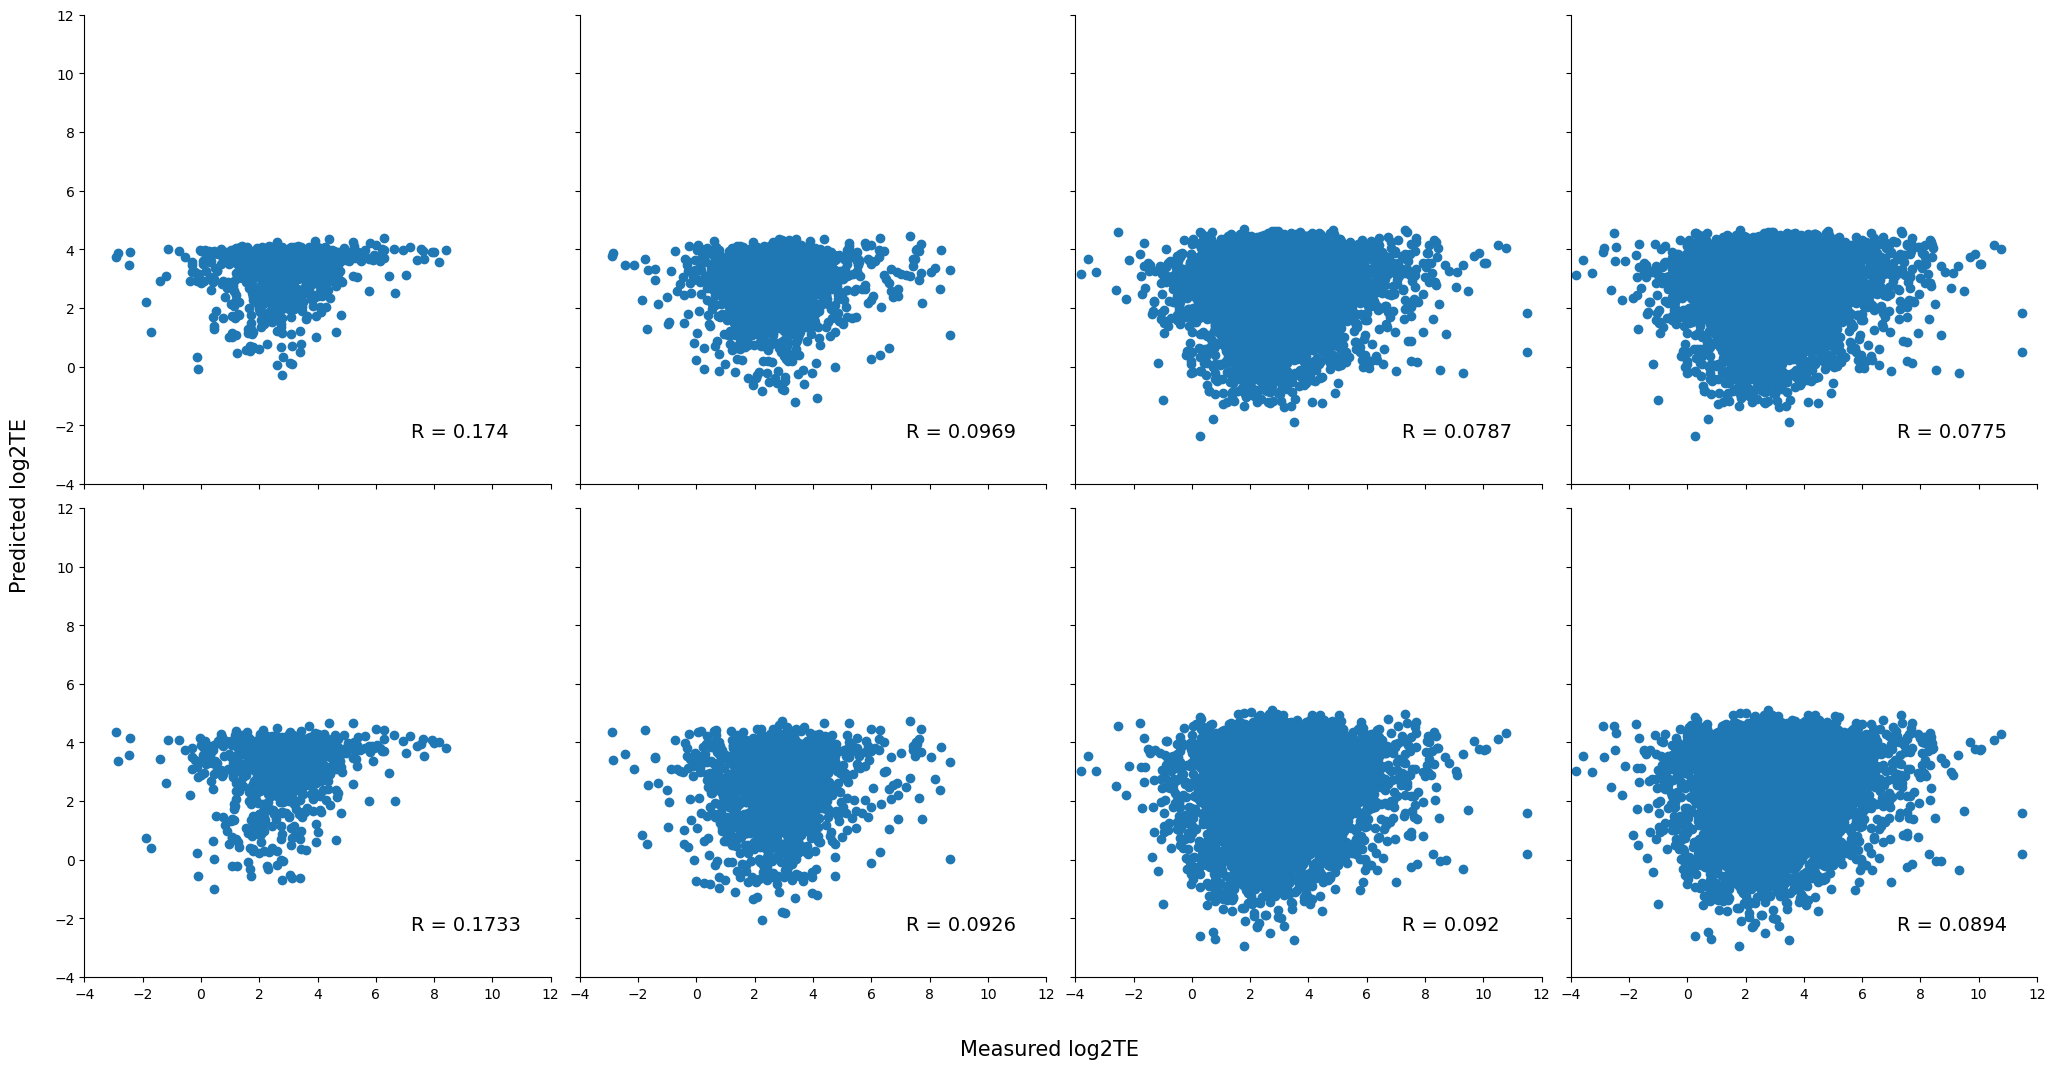

In [33]:
g, ax = plt.subplots(2, 4, layout='constrained', sharex=True, sharey=True, figsize=(20,10))
plt.setp(ax, xlim=(-4,12), ylim=(-4,12))
g.text(0.5, -0.05, 'Measured log2TE', ha='center', fontsize=15)
g.text(-0.02, 0.5, 'Predicted log2TE', va='center', rotation='vertical', fontsize=15)

ax[0,0].scatter(short_utrs['log2TE'],short_utrs['pred_log2TE_o5p'])
ax[0,0].annotate('R = %s' % r(short_utrs['log2TE'],short_utrs['pred_log2TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,0].scatter(short_utrs['log2TE'],short_utrs['pred_log2TE_omrl'])
ax[1,0].annotate('R = %s' % r(short_utrs['log2TE'],short_utrs['pred_log2TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,1].scatter(medium_utrs['log2TE'],medium_utrs['pred_log2TE_o5p'])
ax[0,1].annotate('R = %s' % r(medium_utrs['log2TE'],medium_utrs['pred_log2TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,1].scatter(medium_utrs['log2TE'],medium_utrs['pred_log2TE_omrl'])
ax[1,1].annotate('R = %s' % r(medium_utrs['log2TE'],medium_utrs['pred_log2TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,2].scatter(long_utrs['log2TE'],long_utrs['pred_log2TE_o5p'])
ax[0,2].annotate('R = %s' % r(long_utrs['log2TE'],long_utrs['pred_log2TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,2].scatter(long_utrs['log2TE'],long_utrs['pred_log2TE_omrl'])
ax[1,2].annotate('R = %s' % r(long_utrs['log2TE'],long_utrs['pred_log2TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,3].scatter(utr_data['log2TE'],utr_data['pred_log2TE_o5p'])
ax[0,3].annotate('R = %s' % r(utr_data['log2TE'],utr_data['pred_log2TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,3].scatter(utr_data['log2TE'],utr_data['pred_log2TE_omrl'])
ax[1,3].annotate('R = %s' % r(utr_data['log2TE'],utr_data['pred_log2TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

sns.despine()

**Results**

- Karollus et. al computed pearson R~(0.1-0.2) for the O5P model on their three riboseq datasets; which is similar to this dataset
- The pearson correlation is similar for O5P and OMRL (and probably not statistically significant) for transcripts with 5'UTRs short than 50nt
- Pearson correlation drops for longer sequences, but less so for OptMRL

**Conclusion**

- MPRA-trained models do not generalize to endogenous data
- MPRAs with longer sequences may be able to close the gap to predicting TE of native sequences
- Model retrained on human reporter data gains slight advantage for predicting translation efficiency

**Notes**

- make the paper more about using human data as well for model training and not about the model itself, so that external validation is not necessary
- Where does the ceiling of predictions at log2TE~5 come from?
    - [x] log2-normalization -> nonsense predictions
    - [x] mean-centering (scaling) -> not scaling leads to same distribution, with more compressed values
    - [x] use the original scaler fit on 'human_train.csv' MRL distribution to rescale the output log2TEs -> same distribution, just shifted scaler
    - [x] output neuron activation function -> linear output activation should not introduce problems that caps predictions to a certain value since it scales to infinity
    - [ ] Mahsa: weights may be capped somewhere in the model, which leads to ceiling;
          - batch-norm after each layer may lead to better results

- Conclusion: scaling does not induce the ceiling in the distribution


#### Extended Data

In [3]:
# lets train the model with batch normalization after each layer, although I do not see how this should remove the ceiling

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

history = LossHistory()

def train_MRL(x, y, val_sample, val_target, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
              dropout2=0, dropout3=0.2, nb_epoch=3):
    ''' Build model archicture and fit.'''

    model = Sequential()
    #conv layer 1
    model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(BatchNormalization())
    #conv layer 2
    model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(BatchNormalization())
    #conv layer 3
    model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout2))
    model.add(Flatten())
    model.add(BatchNormalization())
    #dense layer
    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout3))
    #output layer
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1, validation_data=(val_sample, val_target), callbacks = [history])
    return model

def plot_history(model, title='Training History'):
    model_loss = pd.DataFrame(model.history.history)

    fig = plt.figure()
    a = model_loss['loss']
    b = model_loss['val_loss']
    c = np.array(range(1,len(model_loss['loss'])+1,1))
    axes = fig.add_axes([0.0, 0.0, 0.8, 0.8])
    axes.plot(c, a, label='training loss')
    axes.plot(c, b, label='validation loss')
    axes.set_xlim(0, len(model_loss['loss']) + 1)
    axes.set_ylim(0, 1)
    axes.legend(loc=3)
    axes.set(xlabel = 'epoch', ylabel='loss',
             title = title)

In [3]:

tf.config.list_physical_devices('GPU')

2024-06-17 13:38:06.820552: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[]

In [4]:
tf.device('/GPU:0')

2024-06-17 13:39:11.077169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-17 13:39:11.080757: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
#import data
train = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/random_train.csv')
test = onehot_var(pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/random_test.csv'), col='five_utr', seq_len=50)

#encode sequences
seq_train = onehot_var(train, col='utr', seq_len=50)
seq_test = onehot_var(test, col='utr', seq_len=50)

#scale
train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))
test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

#train model
with tf.device('/GPU:0'):
    mrl = train_MRL(seq_train, train['scaled_rl'], seq_test, test['scaled_rl'])

#plot history
plot_history(mrl, title='MRL Model with BatchNorm')

FileNotFoundError: [Errno 2] No such file or directory: '/fast/AG_Ohler/frederick/projects/mlcis/data/random_train.csv'

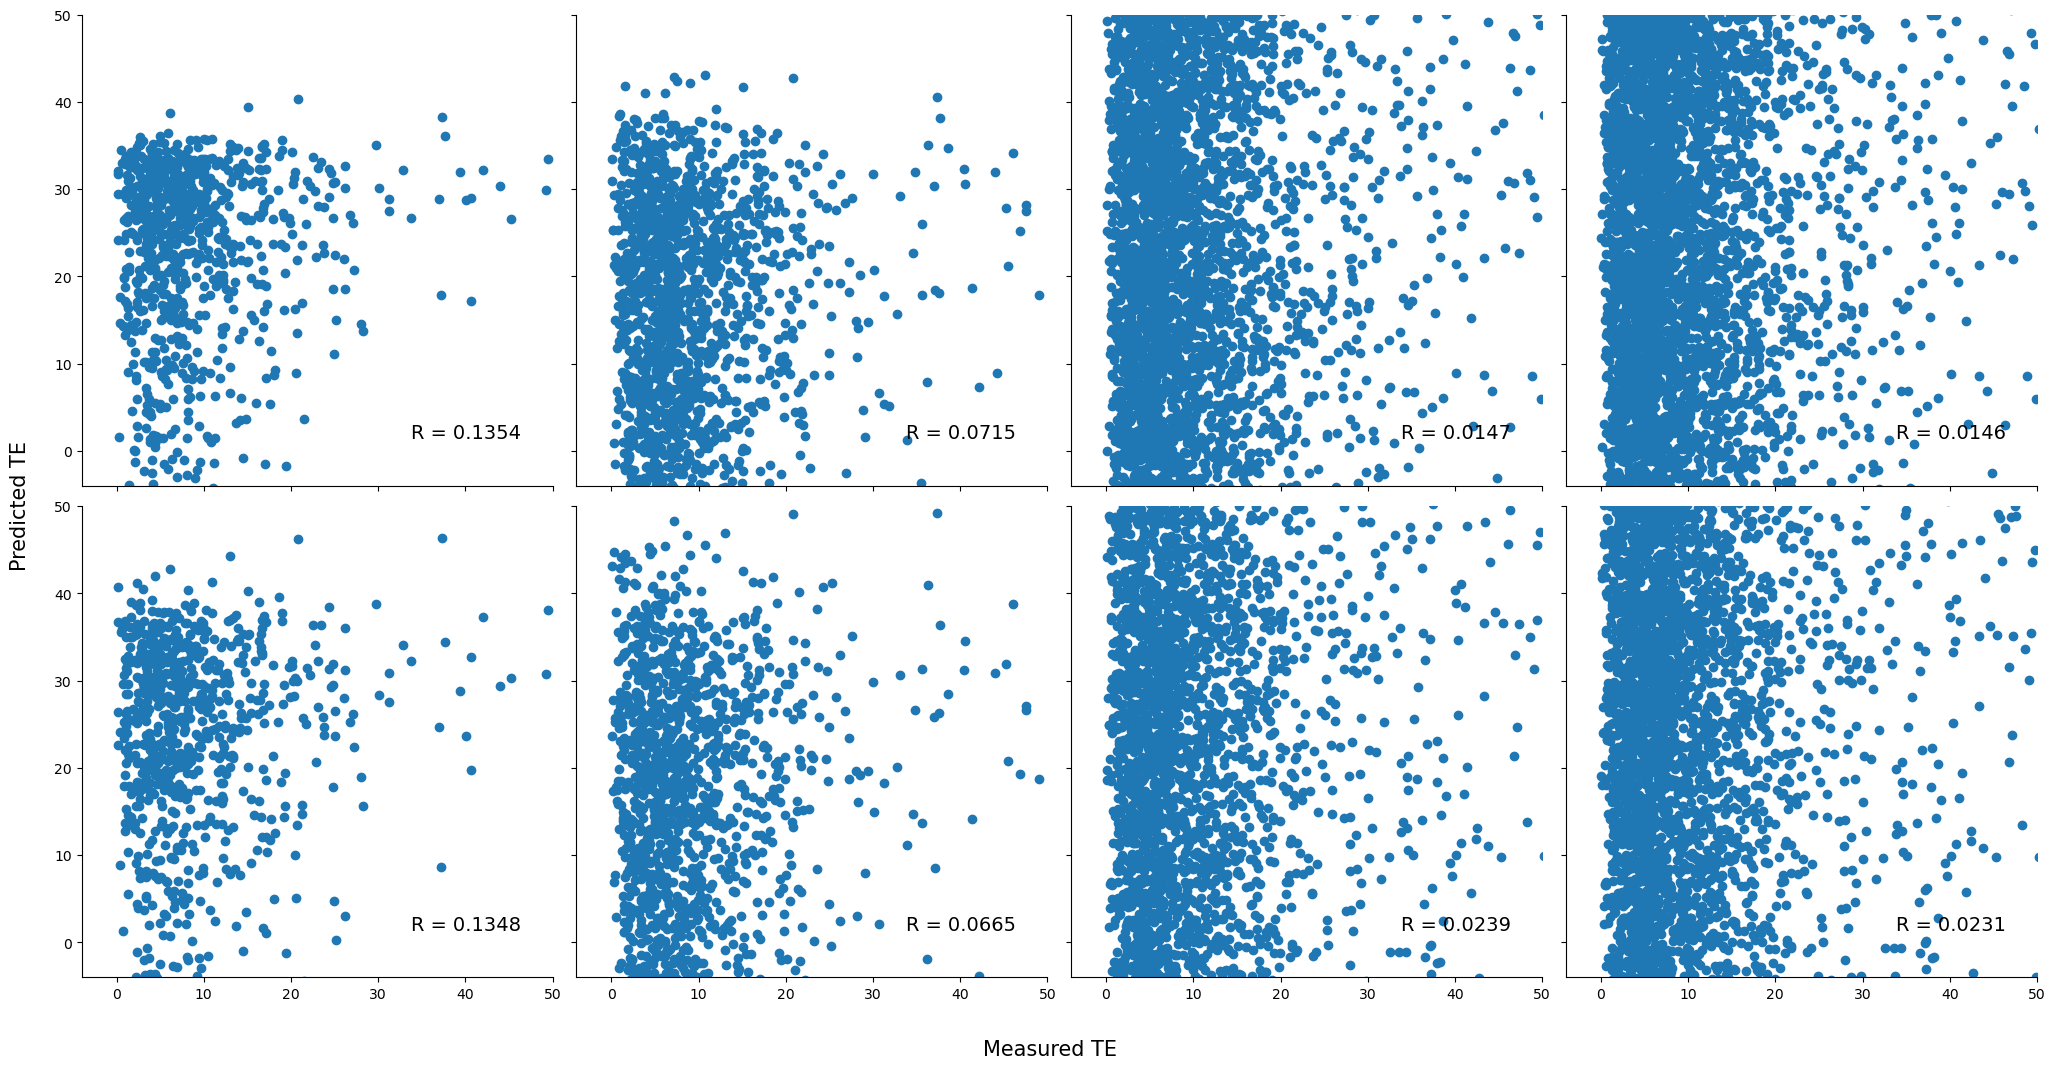

In [21]:
#in this cell, I am testing the effect of log2 scaling of TEs on prediction

g, ax = plt.subplots(2, 4, layout='constrained', sharex=True, sharey=True, figsize=(20,10))
plt.setp(ax, xlim=(-4,50), ylim=(-4,50))
g.text(0.5, -0.05, 'Measured TE', ha='center', fontsize=15)
g.text(-0.02, 0.5, 'Predicted TE', va='center', rotation='vertical', fontsize=15)

ax[0,0].scatter(short_utrs['TE'],short_utrs['pred_TE_o5p'])
ax[0,0].annotate('R = %s' % r(short_utrs['TE'],short_utrs['pred_TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,0].scatter(short_utrs['TE'],short_utrs['pred_TE_omrl'])
ax[1,0].annotate('R = %s' % r(short_utrs['TE'],short_utrs['pred_TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,1].scatter(medium_utrs['TE'],medium_utrs['pred_TE_o5p'])
ax[0,1].annotate('R = %s' % r(medium_utrs['TE'],medium_utrs['pred_TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,1].scatter(medium_utrs['TE'],medium_utrs['pred_TE_omrl'])
ax[1,1].annotate('R = %s' % r(medium_utrs['TE'],medium_utrs['pred_TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,2].scatter(long_utrs['TE'],long_utrs['pred_TE_o5p'])
ax[0,2].annotate('R = %s' % r(long_utrs['TE'],long_utrs['pred_TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,2].scatter(long_utrs['TE'],long_utrs['pred_TE_omrl'])
ax[1,2].annotate('R = %s' % r(long_utrs['TE'],long_utrs['pred_TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[0,3].scatter(utr_data['TE'],utr_data['pred_TE_o5p'])
ax[0,3].annotate('R = %s' % r(utr_data['TE'],utr_data['pred_TE_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax[1,3].scatter(utr_data['TE'],utr_data['pred_TE_omrl'])
ax[1,3].annotate('R = %s' % r(utr_data['TE'],utr_data['pred_TE_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

sns.despine()

(array([  5.,   8.,  11.,  20.,  37.,  59., 101., 171., 360., 118.]),
 array([-2.19855475, -1.86601353, -1.53347242, -1.20093119, -0.86838996,
        -0.5358488 , -0.2033076 ,  0.12923358,  0.46177477,  0.79431599,
         1.12685716]),
 <BarContainer object of 10 artists>)

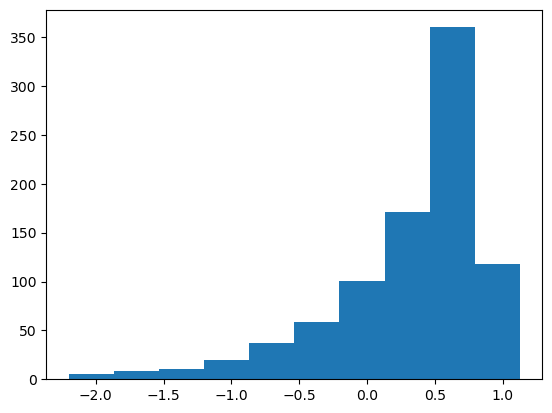

In [30]:
plt.hist(short_utrs['pred_log2TE_o5p'])

In [ ]:
plt.hist(short_utrs['scaled_log2TE'])